# Molecular Property Prediction with DGL-LifeSci

DGL-LifeSci is a DGL-based package for applying graph neural networks (GNNs) to various problems in life science. In this demo, we will develop a GNN for molecular property prediction.

For installation instructions, see [[Github repo]](https://github.com/awslabs/dgl-lifesci)

## Section 1: Graph Construction

The first step for applying GNNs to molecules is to convert a molecule into a graph. The most intuitive option is to construct molecular graphs where nodes correspond to atoms and edges correspond to bonds. The code snippet below plots a molecular graph from a simplified molecular-input line-entry system (SMILES) string with RDKit.

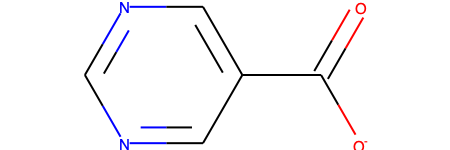

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True
smiles = 'c1ncncc1C(=O)[O-]'
mol = Chem.MolFromSmiles('c1ncncc1C(=O)[O-]')
mol

DGL-LifeSci provides a `MolToBigraph` module for converting an RDKit molecule object to a DGLGraph that represents the corresponding molecular graph. The number of nodes is the same as the number of atoms. The number of edges is twice as the number of bonds because the graph is bi-directed, meanining that $(i, j)$ and $(j, i)$ are distinct edges.

In [2]:
# Mufei: We need to make a new release of dgllife to include MolToBigraph,
#        once we are confident that the tutorial does not need to add more features to dgllife
from dgllife.utils import MolToBigraph

mol_to_g = MolToBigraph()
g = mol_to_g(mol)
print(g)
assert g.num_nodes() == mol.GetNumAtoms()
assert g.num_edges() == 2 * mol.GetNumBonds()

Graph(num_nodes=9, num_edges=18,
      ndata_schemes={}
      edata_schemes={})


Alternative popular graph construction options include for example radius graphs and k nearest neighbor (KNN) graphs, particularly when 3D coordinates of atoms are available. For a full list of graph construction methods in DGL-LifeSci, see https://lifesci.dgl.ai/api/utils.mols.html#graph-construction

## Section 2: Featurization

It takes both structural and feature information for GNNs to work well. Therefore it is an important step to prepare input node and/or edge features for your graphs.

For molecular graphs, it's natural to consider information like atom type/atomic number for node features and bond type for bond features. An example atom featurizer is defined below.

In [3]:
import torch

def atom_mass(atom):
    """
    atom: RDKit atom instance
    """
    return [atom.GetMass() * 0.01]

atom = mol.GetAtomWithIdx(0)
print(atom_mass(atom))

[0.12011]


DGL-LifeSci provides a set of built-in atom and bond featurizer, which can be found at https://lifesci.dgl.ai/api/utils.mols.html#featurization-for-nodes. It's also common to compose multiple featurizers, where `ConcatFeaturizer` can help.

In [4]:
from dgllife.utils import ConcatFeaturizer, atom_formal_charge


atom_featurizer = ConcatFeaturizer([atom_mass, atom_formal_charge])
print(atom_featurizer(atom))

[0.12011, 0]


DGL-LifeSci provides a `BaseAtomFeaturizer` module for applying the featurization to all atoms in a molecule and a `BaseBondFeaturizer` module for applying the featurization to all bonds in a molecule.

In [5]:
from dgllife.utils import BaseAtomFeaturizer

mol_atom_featurizer = BaseAtomFeaturizer({'feat': atom_featurizer})
print('feat size:', mol_atom_featurizer.feat_size())
print(mol_atom_featurizer(mol))

feat size: 2
{'feat': tensor([[ 0.1201,  0.0000],
        [ 0.1401,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1401,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1600,  0.0000],
        [ 0.1600, -1.0000]])}


## Section 3: Dataset Preparation

DGL-LifeSci adopts the widely used comma-separated values (CSV) format for loading a dataset. For demonstration, we first download a data file in CSV format.

In [6]:
from dgl.data.utils import download, _get_dgl_url, extract_archive

url = 'dataset/FreeSolv.zip'
data_path = 'FreeSolv.zip'
download(_get_dgl_url(url), path=data_path)
extract_archive(data_path, './FreeSolv')

The CSV file should have a column for SMILES strings (smiles in the file below) and one or multiple columns for properties (expt and calc in the file below).

In [7]:
import pandas as pd

df = pd.read_csv('FreeSolv/SAMPL.csv')
df.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


DGL-LifeSci provides `MoleculeCSVDataset` for loading a CSV data file along with graph construction and featurization.

In [8]:
from dgllife.data import MoleculeCSVDataset
from dgllife.utils import AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer

node_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='feat')
edge_featurizer = AttentiveFPBondFeaturizer(bond_data_field='feat')
dataset = MoleculeCSVDataset(df, 
                             node_featurizer=node_featurizer,
                             edge_featurizer=edge_featurizer,
                             smiles_column='smiles',
                             task_names=['expt'],
                             cache_file_path='dglgraph.bin')
print('dataset size:', len(dataset))
print(dataset[0])

Processing dgl graphs from scratch...
dataset size: 642
('CN(C)C(=O)c1ccc(cc1)OC', Graph(num_nodes=13, num_edges=26,
      ndata_schemes={'feat': Scheme(shape=(39,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(10,), dtype=torch.float32)}), tensor([-11.0100]), tensor([1.]))


## Section 4: Training

### Dataset Split

First, we need to split the dataset into training, validation, and test subsets. One popular option is scaffold split, which groups molecules based on their Bemis-Murcko scaffolds and then split the groups. This encourages the molecules in the different subsets to be more structurally different, and is believed to better resemble the real world out-of-distribution problem.

In [9]:
from dgllife.utils import ScaffoldSplitter

train_set, val_set, test_set = ScaffoldSplitter.train_val_test_split(
    dataset, frac_train=0.8, frac_val=0.1, 
    frac_test=0.1, scaffold_func='smiles')

Start initializing RDKit molecule instances...
Start computing Bemis-Murcko scaffolds.


### Data Loader

In [10]:
from torch.utils.data import DataLoader

def collate_molgraphs(data):
    smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    labels = torch.stack(labels, dim=0)
    masks = torch.stack(masks, dim=0)

    return smiles, bg, labels, masks

batch_size = 128
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, 
                          shuffle=True, collate_fn=collate_molgraphs)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size,
                        collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size,
                         collate_fn=collate_molgraphs)

### Model Initialization

In [11]:
import torch.nn as nn
from dgllife.model import AttentiveFPPredictor
from torch.optim import Adam

model = AttentiveFPPredictor(
    node_feat_size=node_featurizer.feat_size(),
    edge_feat_size=edge_featurizer.feat_size(),
    n_tasks=dataset.n_tasks
)
loss_criterion = nn.SmoothL1Loss(reduction='none')
optimizer = Adam(model.parameters(), lr=3e-4)

### Train & Eval

In [12]:
import dgl
import numpy as np
from dgllife.utils import Meter

def run_a_train_epoch(model, data_loader, loss_criterion, optimizer):
    model.train()
    train_meter = Meter()
    for _, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        if len(smiles) == 1:
            # Avoid potential issues with batch normalization
            continue
        
        pred = model(bg, bg.ndata['feat'], bg.edata['feat'])
        loss = (loss_criterion(pred, labels) * (masks != 0).float()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.update(pred, labels, masks)
    return np.mean(train_meter.compute_metric('r2'))

def run_an_eval_epoch(model, data_loader):
    model.eval()
    eval_meter = Meter()
    for _, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        pred = model(bg, bg.ndata['feat'], bg.edata['feat'])
        eval_meter.update(pred, labels, masks)
    return np.mean(eval_meter.compute_metric('r2'))

for epoch in range(100):
    train_r2 = run_a_train_epoch(model, train_loader, loss_criterion, optimizer)
    val_r2 = run_an_eval_epoch(model, val_loader)
    print('epoch {:d} | train r2 {:.4f} | val r2 {:.4f}'.format(epoch, train_r2, val_r2))
test_r2 = run_an_eval_epoch(model, test_loader)
print('test r2 {:.4f}'.format(test_r2))

/Users/mufei/miniconda3/envs/dgllife/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch 0 | train r2 0.0063 | val r2 0.0457
epoch 1 | train r2 0.0625 | val r2 0.0480
epoch 2 | train r2 0.0777 | val r2 0.0501
epoch 3 | train r2 0.1091 | val r2 0.0562
epoch 4 | train r2 0.1409 | val r2 0.0616
epoch 5 | train r2 0.1506 | val r2 0.0678
epoch 6 | train r2 0.1654 | val r2 0.0754
epoch 7 | train r2 0.1799 | val r2 0.0834
epoch 8 | train r2 0.1857 | val r2 0.0921
epoch 9 | train r2 0.2046 | val r2 0.1001
epoch 10 | train r2 0.2082 | val r2 0.1082
epoch 11 | train r2 0.2253 | val r2 0.1176
epoch 12 | train r2 0.2394 | val r2 0.1265
epoch 13 | train r2 0.2510 | val r2 0.1368
epoch 14 | train r2 0.2649 | val r2 0.1484
epoch 15 | train r2 0.2808 | val r2 0.1639
epoch 16 | train r2 0.3001 | val r2 0.1821
epoch 17 | train r2 0.3256 | val r2 0.2041
epoch 18 | train r2 0.3528 | val r2 0.2341
epoch 19 | train r2 0.3901 | val r2 0.2744
epoch 20 | train r2 0.4262 | val r2 0.3363
epoch 21 | train r2 0.4691 | val r2 0.3978
epoch 22 | train r2 0.5045 | val r2 0.4822
epoch 23 | train r2 0

Once we have a trained model, we can then save the model and apply it to other molecules if needed.

Section 1-4 is a subset of the command-line interface [here](https://github.com/awslabs/dgl-lifesci/tree/master/examples/property_prediction/csv_data_configuration).

## Section 5: Attention Visualization

AttentiveFP is an attention-based GNN. We can retrieve the attention values of a trained model over a molecule and plot them.

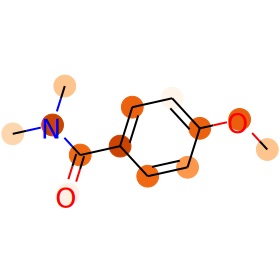

In [13]:
import matplotlib
import matplotlib.cm as cm

from IPython.display import SVG, display
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

smiles, g, _, _ = dataset[0]
_, atom_weights = model(g, g.ndata['feat'], g.edata['feat'], get_node_weight=True)
# atom_weights is a list of length 2
# we use the second suite of atom weights for visualization in this demo
atom_weights = atom_weights[-1]

# min-max normalization to make it easier to distinguish attention values
min_value = torch.min(atom_weights)
max_value = torch.max(atom_weights)
atom_weights = (atom_weights - min_value) / (max_value - min_value)

# Conver the weights to atom colors
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28)
cmap = cm.get_cmap('Oranges')
plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) 
               for i in range(g.num_nodes())}

mol = Chem.MolFromSmiles(smiles)
rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
drawer.SetFontSize(1)
op = drawer.drawOptions()
    
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer.DrawMolecule(mol, highlightAtoms=range(g.num_nodes()),highlightBonds=[],
                    highlightAtomColors=atom_colors)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
svg = svg.replace('svg:','')
display(SVG(svg))